In [142]:
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [143]:

# def init_filter(shape, poolsz):
#     w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
# #     w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:]) / np.prod(poolsz))
# #     w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[1:]))
# #     w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
# #     w = np.random.randn(*shape) 
#     return w.astype(np.float32)

def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

def init_filter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)

def init_weight_and_bias(M1, M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

def error_rate(targets, predictions):
    return np.mean(targets != predictions)

In [163]:
class HiddenLayer(object):
    def __init__(self, mi, mo, an_id):
        self.id = an_id
        self.mi = mi
        self.mo = mo
        
        W, b = init_weight_and_bias(mi, mo)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]
    
    def forward(self, X):
        return tf.nn.relu(tf.add(tf.matmul(X, self.W), self.b))
    
class ConvoPoolLayer(object):
    
    def __init__(self, mi, mo, fw=5, fh=5, poolsz=(2,2)):
        
        filter_sz = (fw, fh, mi, mo)
        
        W = init_filter(filter_sz, poolsz)
        self.W = tf.Variable(W.astype(np.float32))
        
        b = np.zeros(mo)
        self.b = tf.Variable(b.astype(np.float32))
    
        self.poolsz = poolsz
        self.params = [self.W, self.b]
            
    def conv2d(self, X, k=1):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1,k,k,1], padding="SAME")
        conv_out = tf.nn.bias_add(conv_out, self.b)
        return tf.tanh(conv_out)
    
    def maxpool2d(self, conv, poolsz=(2, 2)):
        p1, p2 = poolsz
        return tf.nn.max_pool(conv, ksize=[1, p1, p2, 1], strides=[1, p1, p2, 1], padding="SAME")
    
    def convpool2d(self, X):
        # Convolution Layer
        conv = self.conv2d(X)
        # Max Pooling (down-sampling)
        return self.maxpool2d(conv, self.poolsz)


class CNN(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def fit(self, X, Y, lr=1e-3, mu=0.99, reg=1e-3, decay=0.99999, eps=1e-10, batch_sz=30, epochs=3, show_fig=True):
        
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        
        print("learning rate:", lr)
        print("mu:", mu)
        print("decay:", decay)
        print("reg:", reg)
        
        K = len(set(Y))
        
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y, K).astype(np.float32)
        
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        Yvalid_flat = np.argmax(Yvalid, axis=1)
        X, Y = X[:-1000], Y[:-1000]
        
        N, width, height, color_dim = X.shape
        mi = color_dim
        outw = width
        outh = height
        
        # initialize convpool layers
        self.conv_layers = []
        for mo, fw, fh in self.convpool_layer_sizes:
            conv_layer = ConvoPoolLayer(mi, mo, fw, fh)
            self.conv_layers.append(conv_layer)
            # TODO: encapsulate the outw and outh in the convolutional layer class
            outw = outw // 2
            outh = outh // 2
            print("outw", outw)
            print("outh", outh)
            mi = mo
            
        # initialize mlp layers
        
        # size must be same as output of last convpool layer
        M_in = self.convpool_layer_sizes[-1][0] * outw * outh
        self.hidden_layers = []
        count = 0
        for M_out in self.hidden_layer_sizes:
            hidden_layer = HiddenLayer(M_in, M_out, count)
            self.hidden_layers.append(hidden_layer)
            M_in = M_out
            count += 1
            
        # logistic regression layer
        W, b = init_weight_and_bias(M_in, K)
        self.W = tf.Variable(W, name="W_logreg")
        self.b = tf.Variable(b, name="b_logreg")
                
        # collect parameters for regularization
        self.params = [self.W, self.b]
        for c in self.conv_layers:
            self.params += c.params
        for h in self.hidden_layers:
            self.params += h.params
        
        # set up tensorflow functions and variables
        X_P = tf.placeholder(tf.float32, shape=(None, width, height, color_dim), name = "X_P")
        Y_P = tf.placeholder(tf.float32, shape=(None, K), name="Y_P")
        
        logit = self.forward(X_P)
        prediction_op = self.predict(X_P)
        
        reg_loss = reg * sum([tf.nn.l2_loss(p) for p in self.params])
        loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=Y_P)) + reg_loss
    
        optimizer = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu)
#         optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        train_op = optimizer.minimize(loss_op)
    
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            best_validation_error = 1
            for ep in range(epochs):
                X, Y = shuffle(X, Y)
                t = 0
                for start_i in range(0, N, batch_sz):
                    t += 1
                    end_i = start_i + batch_sz
                    Xbatch = X[start_i:end_i]
                    Ybatch = Y[start_i:end_i]

                    sess.run(train_op, feed_dict={X_P:Xbatch, Y_P:Ybatch})
                        
                    if t % 10 == 0:
                        c = sess.run(loss_op, feed_dict={X_P:Xvalid, Y_P:Yvalid})
                        costs.append(c)
                        
                        p = sess.run(prediction_op, feed_dict={X_P:Xvalid, Y_P:Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("epoch:", ep, "batch:", t, "cost:", c, "error rate:", e)
                        if e < best_validation_error:
                            best_validation_error = e
            print("best_validation_error:", best_validation_error)   
                        
        if show_fig:
            plt.plot(costs)
            plt.show()   
                
            
    def forward(self, X):
        Z = X
        for c in self.conv_layers:
            Z = c.convpool2d(Z)
            
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hidden_layers:
            Z = h.forward(Z)
            
        return tf.add(tf.matmul(Z, self.W), self.b)
    
    def predict(self, X):
        Py = self.forward(X)
        return tf.argmax(Py, 1)    

In [145]:
def getData(balance_ones=True):
    # images are 48x48 = 2304 size vectors
    Y = []
    X = []
    first = True
    for line in open('../data/fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)

    if balance_ones:
        # balance the 1 class
        X0, Y0 = X[Y!=1, :], Y[Y!=1]
        X1 = X[Y==1, :]
        X1 = np.repeat(X1, 9, axis=0)
        X = np.vstack([X0, X1])
        Y = np.concatenate((Y0, [1]*len(X1)))

    return X, Y


def getImageData():
    X, Y = getData()
    N, D = X.shape
    d = int(np.sqrt(D))
    X = X.reshape(N, d, d, 1)
    return X, Y

In [149]:
X, Y = getImageData()
print("X.shape:", X.shape)

X.shape: (40263, 48, 48, 1)


learning rate: 0.001
mu: 0.99
decay: 0.99999
reg: 0.001
outw 24
outh 24
outw 12
outh 12
epoch: 0 batch: 10 cost: 2.35948 error rate: 0.773
epoch: 0 batch: 20 cost: 2.24689 error rate: 0.749
epoch: 0 batch: 30 cost: 2.21064 error rate: 0.77
epoch: 0 batch: 40 cost: 2.14349 error rate: 0.728
epoch: 0 batch: 50 cost: 2.1062 error rate: 0.707
epoch: 0 batch: 60 cost: 2.05768 error rate: 0.694
epoch: 0 batch: 70 cost: 2.0045 error rate: 0.682
epoch: 0 batch: 80 cost: 1.96573 error rate: 0.654
epoch: 0 batch: 90 cost: 1.9397 error rate: 0.632
epoch: 0 batch: 100 cost: 1.88307 error rate: 0.616
epoch: 0 batch: 110 cost: 1.85302 error rate: 0.618
epoch: 0 batch: 120 cost: 1.81923 error rate: 0.6
epoch: 0 batch: 130 cost: 1.78773 error rate: 0.579
epoch: 0 batch: 140 cost: 1.76516 error rate: 0.575
epoch: 0 batch: 150 cost: 1.73827 error rate: 0.576
epoch: 1 batch: 10 cost: 1.71654 error rate: 0.565
epoch: 1 batch: 20 cost: 1.66028 error rate: 0.541
epoch: 1 batch: 30 cost: 1.63622 error rate: 

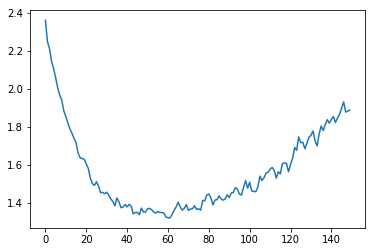

In [164]:
model = CNN(
    convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
    hidden_layer_sizes=[500, 300],
)
model.fit(X, Y, batch_sz=256, epochs=10)

learning rate: 0.001
mu: 0.99
decay: 0.99999
reg: 0.001
outw 24
outh 24
outw 12
outh 12
epoch: 0 batch: 10 cost: 2.33571 error rate: 0.852
epoch: 0 batch: 20 cost: 2.2543 error rate: 0.761
epoch: 0 batch: 30 cost: 2.165 error rate: 0.696
epoch: 0 batch: 40 cost: 2.08892 error rate: 0.675
epoch: 0 batch: 50 cost: 2.02617 error rate: 0.652
epoch: 0 batch: 60 cost: 1.9878 error rate: 0.627
epoch: 0 batch: 70 cost: 1.99326 error rate: 0.668
epoch: 0 batch: 80 cost: 1.91228 error rate: 0.616
epoch: 0 batch: 90 cost: 1.86574 error rate: 0.584
epoch: 0 batch: 100 cost: 1.87064 error rate: 0.619
epoch: 0 batch: 110 cost: 1.79454 error rate: 0.574
epoch: 0 batch: 120 cost: 1.77185 error rate: 0.587
epoch: 0 batch: 130 cost: 1.73082 error rate: 0.567
epoch: 0 batch: 140 cost: 1.72047 error rate: 0.567
epoch: 0 batch: 150 cost: 1.68334 error rate: 0.533
epoch: 1 batch: 10 cost: 1.66718 error rate: 0.546
epoch: 1 batch: 20 cost: 1.673 error rate: 0.553
epoch: 1 batch: 30 cost: 1.61626 error rate: 

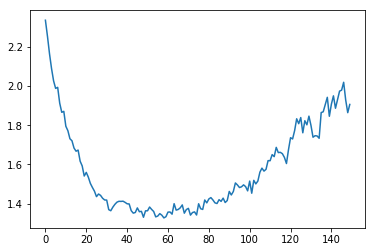

In [165]:
model = CNN(
    convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
    hidden_layer_sizes=[500, 300],
)
model.fit(X, Y, batch_sz=256, epochs=10)